In [1]:
import gymnasium as gym
import numpy as np
import causal_gym
from causal_gym.wrappers import DeployPolicy
from gym.wrappers import RecordVideo
from time import sleep

with open('windy_gridworld_optimal_values.npy', 'rb') as f:
    opt_val = np.load(f)

with open('windy_gridworld_transition.npy', 'rb') as f:
    opt_ps = np.load(f)

env = gym.make('causal_gym/WindyGridWorld-v0',  size = 3)

pygame 2.5.2 (SDL 2.28.3, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def value_iteration(ps, policy):
    theta = 0.1
    max_iterations = 10
    gamma = 1
    values = np.zeros([env.size, env.size])
    for j in range(max_iterations):
        err = 0.0
        new_values = np.zeros([env.size, env.size])
        for x in range(env.size):
            for y in range(env.size):
                qtable = np.zeros(env.action_space.n)

                if x != int(env.size / 2) or y != int(env.size - 1):
                    for a in range(env.action_space.n):
                        # Calculate the value of Q(s,a)
                        new_value = -1
                        for new_x in range(env.size):
                            for new_y in range(env.size):
                                new_value += ps[x, y, a, new_x, new_y] * gamma * values[new_x, new_y]

                        qtable[a] = new_value

                max_q = qtable[policy[x, y]]

                err = np.max([err, np.abs(values[x, y] - max_q)])
                new_values[x, y] = max_q

        values = new_values
        # Terminate if the value function has converged
        if err < theta:
            break
    
    return values

In [3]:
import numpy as np
n1 = np.zeros([env.size, env.size, env.action_space.n])
n2 = np.zeros([env.size, env.size, env.action_space.n, env.size, env.size])
n3 = np.zeros([env.size, env.size])

ps = np.zeros([env.size, env.size, env.action_space.n, env.size, env.size])
px = np.zeros([env.size, env.size, env.action_space.n])
h = np.zeros([env.size, env.size, env.action_space.n, env.size, env.size])
l = np.zeros([env.size, env.size, env.action_space.n, env.size, env.size])


/opt/homebrew/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.size` for environment variables or `env.get_wrapper_attr('size')` that will search the reminding wrappers.
  logger.warn(


In [4]:
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 1
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state, _ = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    terminated = False
    
    while not done and not terminated:

        action, next_state, reward, done, terminated, info = env.see() 

        n1[state['agent'][0], state['agent'][1], action] += 1
        n2[state['agent'][0], state['agent'][1], action, next_state['agent'][0], next_state['agent'][1]] += 1
        n3[state['agent'][0], state['agent'][1]] += 1

        state = next_state
        epochs += 1

for x in range(env.size):
    for y in range(env.size):
        for a in range(env.action_space.n):
            ps[x, y, a] = n2[x, y, a] / np.max([1, n3[x, y]])
            px[x, y, a] = n1[x, y, a] / np.max([1, n3[x, y]])
            
for x in range(env.size):
    for y in range(env.size):
        for a in range(env.action_space.n):
            l[x, y, a] = ps[x, y, a]
            h[x, y, a] = ps[x, y, a] + 1 - px[x, y, a]
            print(x, y, a)
            print(l[x, y, a])
            print(h[x, y, a])

/opt/homebrew/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.see to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.see` for environment variables or `env.get_wrapper_attr('see')` that will search the reminding wrappers.
  logger.warn(


0 0 0
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
0 0 1
[[0.         0.         0.        ]
 [0.104881   0.09713594 0.        ]
 [0.         0.         0.        ]]
[[0.79798306 0.79798306 0.79798306]
 [0.90286406 0.895119   0.79798306]
 [0.79798306 0.79798306 0.79798306]]
0 0 2
[[0.         0.70431626 0.        ]
 [0.         0.0936668  0.        ]
 [0.         0.         0.        ]]
[[0.20201694 0.9063332  0.20201694]
 [0.20201694 0.29568374 0.20201694]
 [0.20201694 0.20201694 0.20201694]]
0 0 3
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
0 1 0
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
0 1 1
[[0.         0.         0.        ]
 [0.         0.         0.09697733]
 [0.         0.         0.        ]]
[[0.90302267 0.90302267 0.90302267]
 [0.90302267 0.90302267 1.        ]
 [0.90302267 0.90302267 0.90302267]]
0 1 2
[[0.         0.10048016 0.70068482]
 [0.         0.         0.10185768]
 [0.      

In [5]:
T = 1000
K = 1

regrets = np.zeros(T)

for x in range(env.size):
    for y in range(env.size):
        for a in range(env.action_space.n):
            for xx in range(env.size):
                for yy in range(env.size):
                    if h[x, y, a, xx, yy] -  l[x, y, a, xx, yy] <= 0.01:
                        print(x, y, a, xx, yy)
                        print(h[x, y, a, xx, yy])

1 0 2 0 0
0.0
1 0 2 0 1
0.10245999522331029
1 0 2 0 2
0.0
1 0 2 1 0
0.09774301409123476
1 0 2 1 1
0.6013852400286601
1 0 2 1 2
0.0983401003104849
1 0 2 2 0
0.0
1 0 2 2 1
0.10007165034630994
1 0 2 2 2
0.0


In [6]:
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 1
delta = 0.1

# For plotting metrics
total_epochs = 0

for k in range(K):
    ns = (l + h)/2 + 0.0001
    ps = np.zeros([env.size, env.size, env.action_space.n, env.size, env.size]) 
    
    regret = 0
    for i in range(T):
        policy = np.zeros([env.size, env.size], dtype=np.int8)

        for x in range(env.size):
            for y in range(env.size):
                for a in range(env.action_space.n):
                        
                    ps[x, y, a] = np.random.dirichlet(ns[x, y, a].reshape(1, env.size*env.size)[0], 1).reshape(env.size, env.size)
                    ps[x, y, a] = np.minimum(np.maximum(ps[x, y, a], l[x, y, a]), h[x, y, a])


                    
        theta = 0.1
        max_iterations = 10
        values = np.zeros([env.size, env.size])
        for j in range(max_iterations):
            err = 0.0
            new_values = np.zeros([env.size, env.size])
            for x in range(env.size):
                for y in range(env.size):
                    qtable = np.zeros(env.action_space.n)

                    if x != int(env.size / 2) or y != int(env.size - 1):
                        for a in range(env.action_space.n):
                            # Calculate the value of Q(s,a)
                            new_value = -1
                            for new_x in range(env.size):
                                for new_y in range(env.size):
                                    new_value += ps[x, y, a, new_x, new_y] * gamma * values[new_x, new_y]

                            qtable[a] = new_value

                    max_q = np.max(qtable)
                    policy[x, y] = np.argmax(qtable)

                    err = np.max([err, np.abs(values[x, y] - max_q)])
                    new_values[x, y] = max_q

            values = new_values
            # Terminate if the value function has converged
            if err < theta:
                break

        state, _ = env.reset()

        opt_v = opt_val[state['agent'][0], state['agent'][1]]
        rewards = value_iteration(opt_ps, policy)[state['agent'][0], state['agent'][1]]

        epochs = 0
        done = False
        terminated = False
        while not done and not terminated:
            action = policy[state['agent'][0], state['agent'][1]]

            next_state, reward, done, terminated, info = env.do(action)

            ns[state['agent'][0], state['agent'][1], action, next_state['agent'][0], next_state['agent'][1]] += 1

            state = next_state
            epochs += 1    

        total_epochs += epochs
        regret += opt_v - rewards
        regrets[i] += regret
        
        if (i+1) % 100 == 0:
            clear_output(wait=True)
            print(f"Repetition {k}, Episode: {i}")
            print(np.transpose(policy))

print("Training finished.\n")
regrets = regrets / K
env.close()

Repetition 0, Episode: 599
[[2 2 2]
 [2 2 2]
 [1 0 3]]


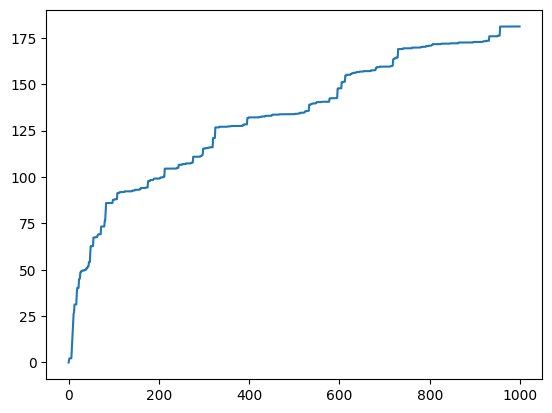

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(T), regrets)
plt.show()

In [ ]:
#with open('windy_gridworld_ts+.regret', 'wb') as f:
#    np.save(f, regrets)